# Text Classification Project: Hate Speech, Offensive Language, Neither



## Install Required Packages

In [2]:

!pip install numpy pandas matplotlib seaborn nltk scikit-learn tensorflow keras gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00


## Import Required Libraries

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import gradio as gr

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

data = pd.read_csv('/content/drive/MyDrive/Deeplearning/hatevsoffensive_language.csv')
print('Dataset shape:', data.shape)
data.head()


Dataset shape: (24783, 2)


,label,text
0,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,offensive language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,offensive language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,offensive language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,offensive language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Explore and Clean Data

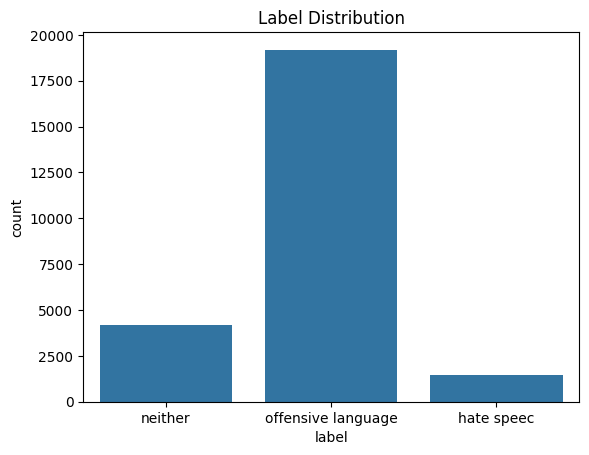

,text,clean_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house amp man...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [5]:

sns.countplot(x='label', data=data)
plt.title('Label Distribution')
plt.show()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\brt\b", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text


data['clean_text'] = data['text'].apply(clean_text)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['clean_text'] = data['clean_text'].apply(preprocess_text)

data[['text', 'clean_text']].head()


## Visualize Cleaned Text

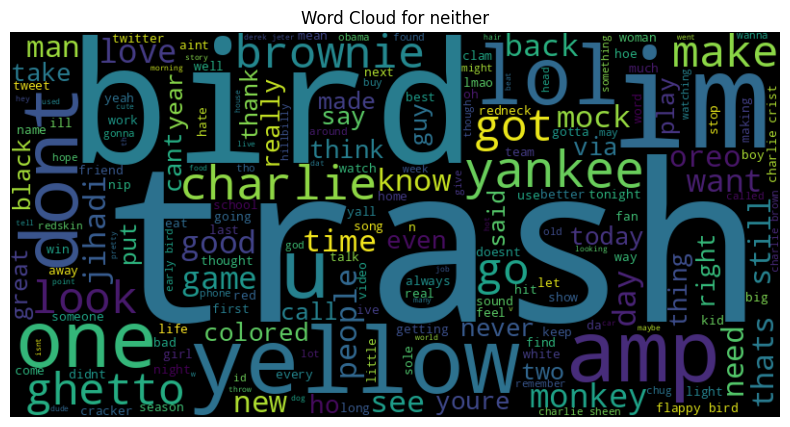

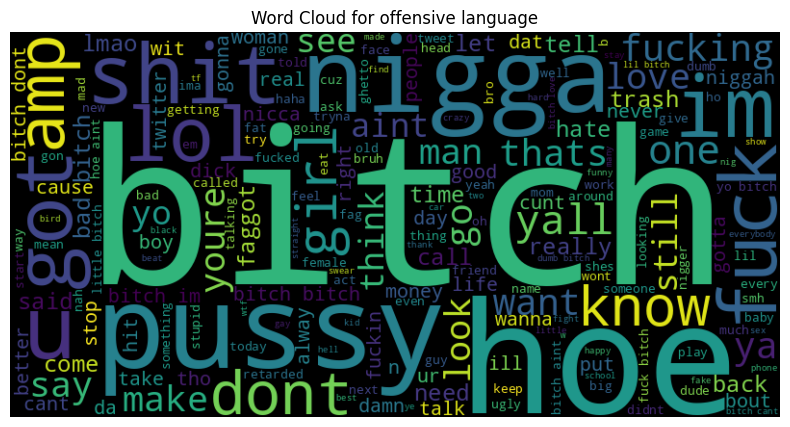

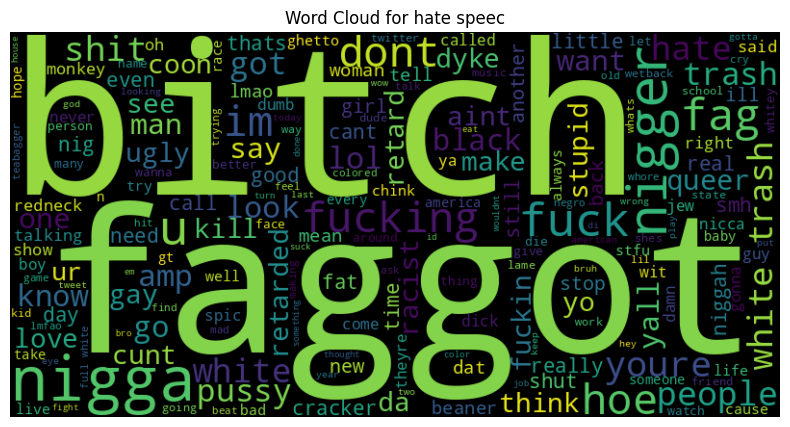

In [6]:
for label in data['label'].unique():
    subset = data[data['label'] == label]
    text = ' '.join(subset['clean_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')
    plt.show()


## Encode Labels and Split Data

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = data[data['label'].isin(['offensive language', 'neither'])]

label_encoder = LabelEncoder()
data['label_num'] = label_encoder.fit_transform(data['label'])

print("Label Encoding Mapping:")
for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label} → {encoded}")

X = data['clean_text']
y = data['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Class distribution in training set:\n{y_train.value_counts()}")


Label Encoding Mapping:
neither → 0
offensive language → 1
Class distribution in training set:
label_num
1    15342
0     3340
Name: count, dtype: int64


## Tokenization and Padding

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
lengths = [len(x) for x in X_train_seq]
maxlen = int(np.percentile(lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_array = compute_class_weight(class_weight='balanced',
                                           classes=np.unique(y_train),
                                           y=y_train)

class_weights = dict(enumerate(class_weights_array))

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(2.7967065868263474), 1: np.float64(0.6088515187068179)}


## Build Models

# RNN

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import time
import numpy as np

X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train)

def build_improved_simple_rnn():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
        SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])
    model.build(input_shape=(None, maxlen))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

model_rnn = build_improved_simple_rnn()
model_rnn.summary()

callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 14, 50)         │       775,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 14, 64)         │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,597 (3.00 MB)

 Trainable params: 785,597 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
start = time.time()
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

print(f"Improved Simple RNN training time: {time.time() - start:.2f} seconds")

Epoch 1/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.5228 - loss: 1.6860 - val_accuracy: 0.7899 - val_loss: 1.3786
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7178 - loss: 1.3589 - val_accuracy: 0.8534 - val_loss: 1.0924
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8672 - loss: 1.0133 - val_accuracy: 0.8959 - val_loss: 0.8969
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9083 - loss: 0.8381 - val_accuracy: 0.8994 - val_loss: 0.8143
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9260 - loss: 0.7069 - val_accuracy: 0.9259 - val_loss: 0.6591
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9439 - loss: 0.5941 - val_accuracy: 0.9283 - val_loss: 0.5853
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9529 - loss: 0.5068 - val_accuracy: 0.9227 - val_loss: 0.5430
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9599 - loss: 0.4280 - 

In [36]:
model_rnn.save('/content/drive/MyDrive/Deeplearning/simple_rnn_model.h5')


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

=== Simple RNN ===
Accuracy: 0.9317
              precision    recall  f1-score   support

           0       0.76      0.91      0.82       823
           1       0.98      0.94      0.96      3848

    accuracy                           0.93      4671
   macro avg       0.87      0.92      0.89      4671
weighted avg       0.94      0.93      0.93      4671



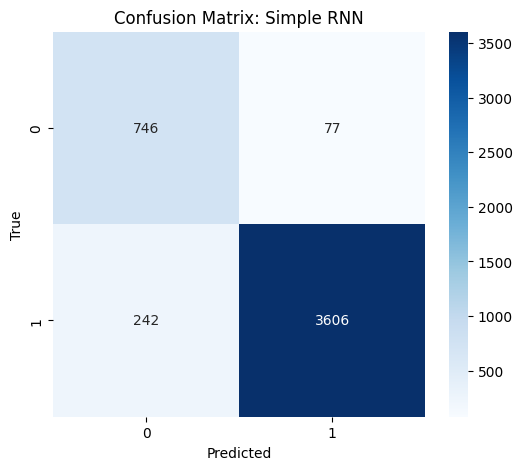

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_test, y_test, name):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(cr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

evaluate_and_plot(model_rnn, X_test_pad, y_test, "Simple RNN")

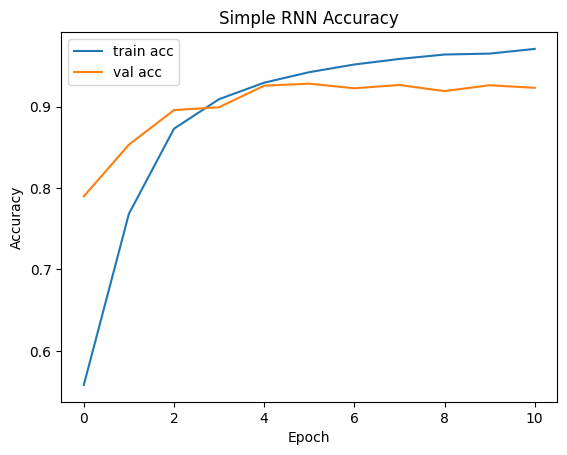

In [34]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_rnn, 'Simple RNN Accuracy')

# LSTM

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import time

def build_further_improved_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen),
        Dropout(0.4),
        LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.02)),
        Dropout(0.4),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02))
    ])
    model.build(input_shape=(None, maxlen))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

model_lstm = build_further_improved_lstm_model()
model_lstm.summary()

callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 14, 100)        │     1,550,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,567,257 (5.98 MB)

 Trainable params: 1,567,257 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
start = time.time()
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)
print(f"Further Improved LSTM training time: {time.time() - start:.2f} seconds")

Epoch 1/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.5213 - loss: 2.5606 - val_accuracy: 0.8467 - val_loss: 1.6023
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.8687 - loss: 1.3078 - val_accuracy: 0.8558 - val_loss: 0.6830
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8759 - loss: 0.6329 - val_accuracy: 0.8852 - val_loss: 0.4498
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9073 - loss: 0.4216 - val_accuracy: 0.9055 - val_loss: 0.3519
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9267 - loss: 0.3283 - val_accuracy: 0.9104 - val_loss: 0.3179
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9328 - loss: 0.2773 - val_accuracy: 0.9106 - val_loss: 0.3022
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9342 - loss: 0.2662 - val_accuracy: 0.9264 - val_loss: 0.2755
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9480 - loss: 0.2400 - 

In [52]:
model_rnn.save('/content/drive/MyDrive/Deeplearning/simple_lstm_model.h5')

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

=== LSTM ===
Accuracy: 0.9368
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       823
           1       0.97      0.95      0.96      3848

    accuracy                           0.94      4671
   macro avg       0.88      0.91      0.90      4671
weighted avg       0.94      0.94      0.94      4671



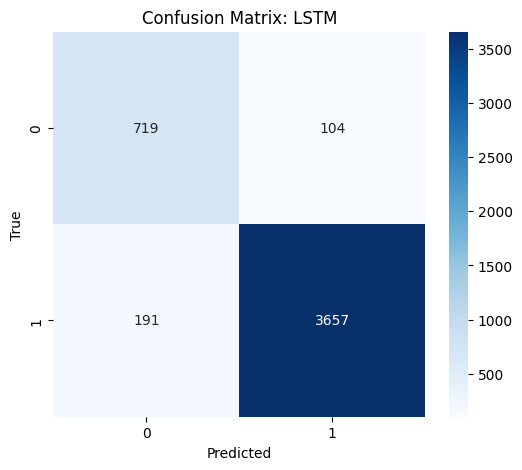

In [56]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_test, y_test, name):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(cr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

evaluate_and_plot(model_lstm, X_test_pad, y_test, "LSTM")

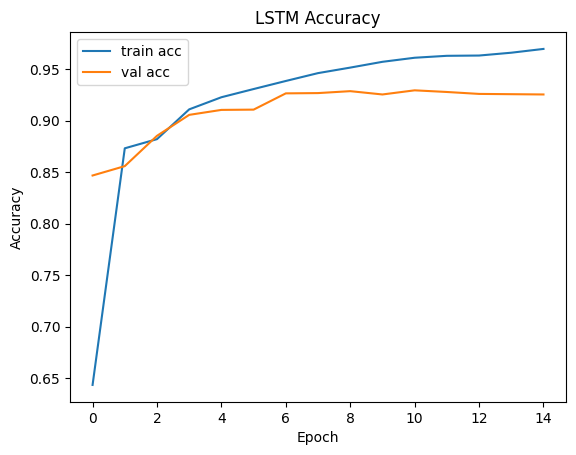

In [54]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history(history_lstm, 'LSTM Accuracy')

# LSTM + GloVe

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def build_lstm_glove():
    embeddings_index = {}
    with open('glove.6B.50d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        Dropout(0.2),
        LSTM(32, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])
    model.build(input_shape=(None, maxlen))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def lr_scheduler(epoch, lr):
    if epoch > 5:
        return lr * 0.5
    return lr

model_glove = build_lstm_glove()
model_glove.summary()

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    LearningRateScheduler(lr_scheduler)
]

start = time.time()
history_glove = model_glove.fit(X_train_pad, y_train, epochs=15, validation_split=0.2, callbacks=callbacks)
print(f"LSTM + GloVe training time: {time.time() - start:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 14, 50)         │       775,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,885 (3.00 MB)

 Trainable params: 10,721 (41.88 KB)

 Non-trainable params: 775,164 (2.96 MB)

Epoch 1/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7600 - loss: 0.9229 - val_accuracy: 0.8544 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 2/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8981 - loss: 0.3465 - val_accuracy: 0.8943 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9083 - loss: 0.2878 - val_accuracy: 0.9098 - val_loss: 0.2614 - learning_rate: 0.0010
Epoch 4/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9076 - loss: 0.2645 - val_accuracy: 0.9152 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9174 - loss: 0.2479 - val_accuracy: 0.9162 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9139 - loss: 0.2427 - val_accuracy: 0.9125 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9205 - loss: 

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

=== LSTM + GloVe ===
Accuracy: 0.9287
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       823
           1       0.96      0.96      0.96      3848

    accuracy                           0.93      4671
   macro avg       0.88      0.88      0.88      4671
weighted avg       0.93      0.93      0.93      4671



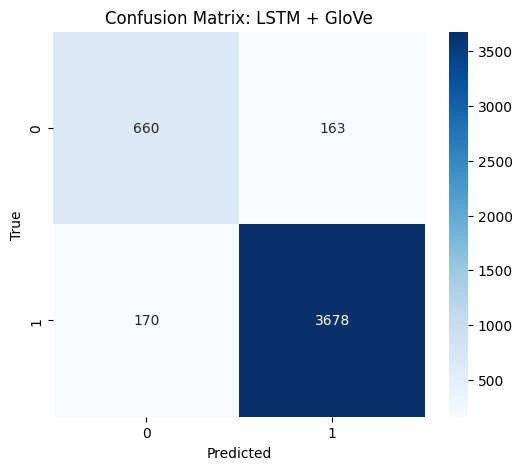

In [64]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_test, y_test, name):

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(cr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

evaluate_and_plot(model_glove, X_test_pad, y_test, "LSTM + GloVe")


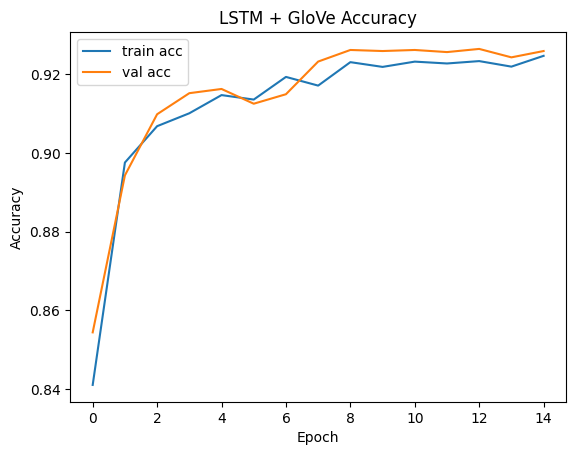

In [65]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history(history_glove, 'LSTM + GloVe Accuracy')


In [28]:
model_glove.save('/content/drive/MyDrive/Deeplearning/lstm_glove_model.h5')


## Real-Time Prediction GUI with Gradio

In [29]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gradio as gr

model_glove = load_model('/content/drive/MyDrive/Deeplearning/lstm_glove_model.h5')

def clean_text(text):
    return text.lower()

def preprocess_text(text):
    return text

maxlen = 14

def predict_comment(text):
    cleaned = preprocess_text(clean_text(text))
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')
    pred_prob = model_glove.predict(pad, verbose=0)[0][0]
    print(f"Input: {text}")
    print(f"Prediction probability: {pred_prob:.4f}")
    pred = 1 if pred_prob > 0.7 else 0  # Adjusted threshold
    return "hate speech/offensive language" if pred == 1 else "neither"

interface = gr.Interface(
    fn=predict_comment,
    inputs=gr.Textbox(label="Enter a comment to classify"),
    outputs=gr.Textbox(label="Prediction"),
    title="Hate Speech/Offensive Language Classifier",
    description="Enter a comment to classify it as 'hate speech/offensive language' or 'neither' using an LSTM + GloVe model."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3576163cce2de721a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
